# Localization with a known map  - Tutorial: Part 1

Localization with a known map, where the map is given as family of line segments. Moreover we optionally allow the environment to be clutterd with additional boxes, which are not mapped. We refer to such a map as _idealized_.



In [1]:
# This is a fix for vscode, because it doesn't like my
# julia docstrings for whatever reason, and throws a `Katex` error.
using Markdown
Base.show(io::IO, ::MIME"text/latex", md::Markdown.MD) = plain(io, md)

In [2]:
#nbx --fname="src/localization_part_1.jl"
push!(LOAD_PATH, "../src");
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src");
using BenchmarkTools;
using CUDA
using LaTeXStrings
using Colors, Plots, Images;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using Fmt # Python-style f-strings
using MyUtils
using StatsBase: mean
using Random: shuffle
include("../src/pose.jl");
include("src/plotting.jl");

In [3]:
#nbx
# Load the environment and poses
include("src/house_expo_data.jl");

Loading `../data/data_4.jld2` ...

	_segs      Vector{Segment}
	_boxes     Vector{Segment}
	_center    Vector{Float64}
	_xs        Vector{Vector{Float64}}
	_hds       Vector{Float64}
	_ps        Vector{Pose}
	_dxs       Vector{Vector{Float64}}
	_dhds      Vector{Float64}
	_us        Vector{Control}
	_T         Int64


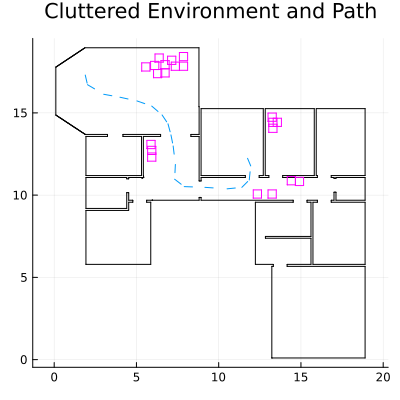

In [4]:
# -----------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing, title="Cluttered Environment and Path")
plot!(_segs, c=:black, linewidth=1)
plot!(_boxes, c=:magenta)
plot!(_ps, c=col[1])

Note that the data does not contain any measurement data. We are going take those measurement ourselves. To do so
let's include some files with deterministic depth sensors so we can make measurements. 

In [4]:
#nbx
include("../src/cuda_raycaster_line_map_b.jl")

_fov = 2π
_num_a = 361
_as  = [range(-_fov/2, _fov/2, _num_a)...];

_segs_  = CuArray(stack(Vector.(_segs)));
_boxes_ = CuArray(stack(Vector.(_boxes)));
_ps_    = CuArray(stack(Vector.(_ps)));
_as_    = CuArray(_as);


# Todo: This should be computed in the data file, but 
#       it also depens on `fov` so ...whatever
zs_ = cast_cu(_ps_, vcat(_segs_, _boxes_); fov=_fov)
_zs = unstack(Array(zs_));
_ys = [polar_inv(z,_as) for z in _zs]

print("""
_segs_   $(typeof(_segs_)) 
_boxes_  $(typeof(_boxes_)) 
_ps_     $(typeof(_ps_)) 
_as_     $(typeof(_as_)) 

_fov     $(typeof(_fov)) 
_as      $(typeof(_as))
_zs      $(typeof(_zs)) 
_ys      $(typeof(_ys)) 
""")

_segs_   CuArray{Float64, 2, CUDA.Mem.DeviceBuffer} 
_boxes_  CuArray{Float64, 2, CUDA.Mem.DeviceBuffer} 
_ps_     CuArray{Float64, 2, CUDA.Mem.DeviceBuffer} 
_as_     CuArray{Float64, 1, CUDA.Mem.DeviceBuffer} 

_fov     Float64 
_as      Vector{Float64}
_zs      Vector{Vector{Float64}} 
_ys      Vector{Vector{Vector{Float64}}} 


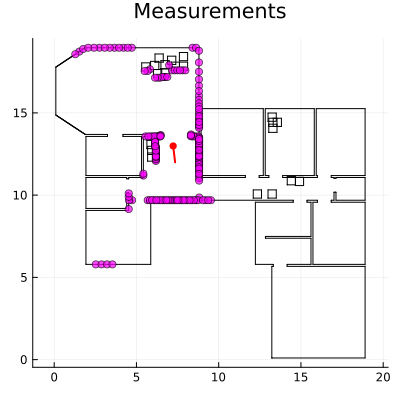

In [6]:
t = 10
p = _ps[t]
y = _ys[t]

# -----------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing, title="Measurements")
plot!(_segs, c=:black, linewidth=1)
plot!(_boxes, c=:black)
scatter!(p, c=:red, r=1.0, linewidth=2)
scatter!(shuffle(y[1:2:end]).*p, c=:magenta, markersize=4, alpha=.7, markerstrokewidth=1)

The agent will only have access to 
- the observations (`_zs` and `_as`; or the Euclidean version `_ys`), 
- the idealized map (`_segs`), and 
- a perturbed version of the controls (`_us_noisy`; wil lbe constructrd below).

Its goal is localize itself on the idealized map.

## Model parts

A couple of distributions we need down the line: a diagonal normal distribution `diagnormal` and a multivariate uniform distribution `mvuniform`.

In [5]:
#nbx
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src")
using GenDistributionZoo: ProductDistribution, diagnormal

mvuniform = ProductDistribution(uniform);
mvuniform(zeros(2), ones(2))

2-element Vector{Float64}:
 0.18303230021617
 0.01678684102609629

### Pose-prior model

In [6]:
#nbx
"""
    p = pose_prior_model(p=nothing, x_noise=0.25, hd_noise=45.)

Model depends on global variable `_bb`.
"""
@gen function pose_prior_model(p=nothing, x_noise=0.25, hd_noise=45/360*2π, bb=_bb)
    # Todo: better signature would be to ask if p is pose or a bounding box
    if p == nothing
        x  ~ mvuniform(bb...)
        hd ~ uniform(0,2π)
    else
        x  ~ diagnormal(p.x, [x_noise, x_noise])
        hd ~ normal(p.hd, hd_noise)
    end
    return Pose(x, hd)
end;

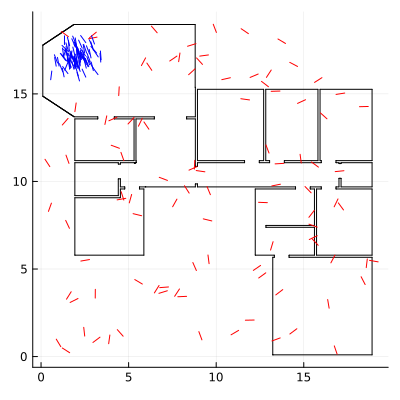

In [12]:
ps = [pose_prior_model(nothing) for t=1:100]
qs = [pose_prior_model(_ps[1], .5, 15/360*2π) for t=1:100]

# ----------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
plot!(ps,c=:red)
plot!(qs,c=:blue)

### Control Prior

We don't use the prior at the moment. We assume the controls are given.

In [7]:
#nbx
@gen function control_prior_model(dx_noise=0.25, dhd_noise=45/360*2π)
    dx  ~ diagnormal([0;0], [dx_noise, dx_noise])
    dhd ~ normal(0, dhd_noise)
    return Control(dx, dhd)
end;

### Motion model

In [8]:
#nbx
"""
    q = motion_model(p, u, x_noise, hd_noise)

Sample a new pose `q` given the previous pose `p`, 
some control data `u = Control(dx, dhd)`, and noise levels
`x_noise` and `hd_noise`.
"""
@gen function motion_model(p, u, x_noise, hd_noise)
    dx, dhd = u.dx, u.dhd
    x   ~ diagnormal(p.x  + dx , [x_noise, x_noise])
    hd  ~ normal(p.hd + dhd, hd_noise)
    return Pose(x, hd)
end;

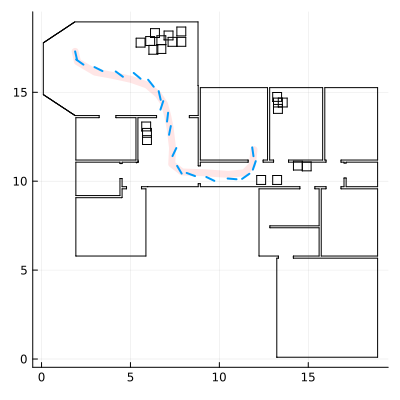

In [15]:
ps = Pose[_ps[1]]

for u in _us
    p = motion_model(ps[end], u, 1e-1, 2\pi * 1e-1)       
    push!(ps, p)
end
ps = [p for p in ps]

# ---------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black, linewidth=1)
plot!(_boxes, c=:black, linewidth=1)
plot!([p.x for p in _ps], c=:red, linewidth=7, alpha=0.1)
plot!(ps, c=col[1], linewidth=2)

### Sensor model

In [9]:
#nbx
include("src/sensor_distribution.jl")

In [71]:
gm             = HomogeneousMixture(diagnormal, [1, 1])
outlier_dist   = diagnormal
sensor_mix     = HeterogeneousMixture([gm, outlier_dist])
sensor_product = ProductDistribution(sensor_mix)

function sensor_product_args(ỹ, sig, outlier, outlier_vol, zmax) 
    n,m, = size(ỹ)
    ỹ_perm = permutedims(ỹ, (1,3,2))
    args = (
        fill([1-outlier, outlier], n), 
        fill(1/m, n, m), 
        ỹ_perm, 
        fill(sig, n, 2,m), 
        fill(0.0, n,2), 
        fill(zmax, n,2)
    )
    return args
end

ỹ = rand(361, 21, 2)
sig         = 0.1
outlier     = 0.1
outlier_vol = 100.
zmax        = 100.
args = sensor_product_args(ỹ, sig, outlier, outlier_vol, zmax) 
x = sensor_product(args...)

@btime sensor_product($args...) samples=3 evals=3;
@btime logpdf($sensor_product, $x, $args...) samples=3 evals=3;

  2.568 ms (16843 allocations: 1.02 MiB)
  16.286 ms (161736 allocations: 5.66 MiB)


In [ ]:
# #nbx
# @gen function sensor_model_v0(p, segs_, w, sig, outlier, outlier_vol, zmax)
#     p_  = CuArray(Vector(p))
#     ps_ = reshape(p_, 1, 3)
#     zs_ = cast_cu(ps_, segs_; fov=_fov)
    
#     ỹ_ = get_ys_tilde_cu(zs_, _as_, w)[1,:,:,:]
#     ỹ  = Array(ỹ_)
#     n,m, = size(ỹ)

#     x = []
#     for i=1:n
#         x_i = {i} ~ sensor_mix(sensor_mix_args(ỹ[i,:,:], sig, outlier, outlier_vol, zmax)...)
#         push!(x,x_i)
#     end    
#     return x
# end;


In [95]:
@gen function sensor_model_v1(p, segs_, w, sig, outlier, outlier_vol, zmax)
    p_  = CuArray(Vector(p))
    ps_ = reshape(p_, 1, 3)

    zs_ = cast_cu(ps_, segs_; fov=_fov)    
    ỹ_  = get_ys_tilde_cu(zs_, _as_, w)[1,:,:,:]
    ỹ   = Array(ỹ_)

    args = sensor_product_args(ỹ, sig, outlier, outlier_vol, zmax) 
    x ~ sensor_product(args...)
    
    return x
end;

In [67]:
t = 7

p  = _ps[t]
m_ = _segs_

w            = 5
s_noise      = 0.2
outlier      = 0.1
outliver_vol = 100.0
zmax         = 100.0


args  = (p, m_, w, s_noise, outlier, outliver_vol, zmax)
sensor_model_v1(args...)
tr = simulate(sensor_model_v1, args);
get_choices(tr)

│
└── :x : [[-4.957135932730119, 0.23344818975590012], [-4.930686043734448, -0.46061432797807456], [-5.173332629753351, -0.4331791630727574], [-5.354378703686955, -0.35908880446656866], [-5.133805399263059, 0.02471163655611939], [2.109740768998251, 161.75158761459437], [-4.687595598165025, -0.3781778865359089], [-5.187953057506055, -0.46734384133880413], [-4.884043851057951, -0.31320671663962474], [-5.5188545098207875, -1.20554603839065], [-5.509115129442981, -1.0695573143838368], [-5.997898404410539, -1.6218634245193042], [-5.8018193192394545, -1.6517953809213108], [-5.5588238665160565, -0.5444023261082145], [-6.116794383635492, -1.3424106381271879], [118.05378701013527, -42.926109659443576], [-6.2097952889365615, -2.6587920092167394], [-6.097191998175844, -1.2742747509286587], [-105.55172159259476, 15.68070582412759], [-6.109542413253791, -1.577743161086025], [-6.407262776909532, -1.443400276426864], [-6.14056672012629, -2.01342428360327], [-5.855713964528354, -2.5277991465392495], [

In [73]:
t = 7

p  = _ps[t]
m_ = _segs_

w            = 5
s_noise      = 0.2
outlier      = 0.1
outlier_vol = 100.0
zmax = 100


args  = (p, m_, w, s_noise, outlier, outlier_vol, zmax)
x  = sensor_model_v1(args...)
ch = choicemap(:x => x)

@btime sensor_model_v1($args...)              samples=5 evals=5;
@btime simulate($sensor_model_v1, $args)      samples=5 evals=5;
@btime generate($sensor_model_v1, $args, $ch) samples=5 evals=5;

  2.468 ms (17367 allocations: 1.01 MiB)
  12.446 ms (110487 allocations: 4.20 MiB)
  10.360 ms (93567 allocations: 3.38 MiB)


Difference between `simulate` and `generate` comes from the additional sampling time. Both need to evaluate.

```julia
  2.441 ms (17352 allocations: 1.01 MiB)
  12.194 ms (110495 allocations: 4.20 MiB)
  10.197 ms (93567 allocations: 3.38 MiB)
```

In [97]:
@btime CuArray(stack(Vector.(_segs)));

  54.898 μs (436 allocations: 60.73 KiB)


427×4 CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}:
 13.24  0.1   13.23  0.11
 13.23  0.11  13.23  5.67
 13.23  5.67  13.31  5.67
 13.31  5.67  13.32  5.68
 13.32  5.68  13.32  5.78
 13.32  5.78  13.31  5.79
 13.31  5.79  12.24  5.79
 12.24  5.79  12.23  5.8
 12.23  5.8   12.23  9.57
 12.23  9.57  14.52  9.57
 14.52  9.57  14.53  9.58
 14.53  9.58  14.53  9.68
 14.53  9.68  14.52  9.69
  ⋮                  
 12.84  7.48  12.84  7.39
 12.84  7.39  12.85  7.38
 12.85  7.38  15.61  7.38
 15.61  7.38  15.61  5.79
 15.61  5.79  14.17  5.79
 14.17  5.79  14.16  5.78
 14.16  5.78  14.16  5.68
 14.16  5.68  14.17  5.67
 14.17  5.67  18.9   5.67
 18.9   5.67  18.9   0.1
 18.9   0.1   13.24  0.1
 13.24  0.1   13.24  0.1

In [99]:
#nbx
@gen function sensor_model(p, segs, w, s_noise, outlier, outlier_vol, zmax=100.0)
    segs_ = CuArray(stack(Vector.(_segs)))
    p_    = CuArray(Vector(p))
    ps_   = reshape(p_, 1, 3)

    zs_      = cast_cu(ps_, segs_; fov=_fov)
    as_      = CuArray(_as)
    y_tilde_ = get_ys_tilde_cu(zs_, as_, w)[1,:,:,:]

    x ~ sensordist_cu(y_tilde_, s_noise, outlier, outlier_vol)    
    return x
end;

In [85]:
@doc sensordist_cu

```julia
    x = sensordist_cu(ỹ_::CuArray, sig, outlier, outlier_vol=1.0)::Vector{Vector{Float64}}
```

Distribution from the 2dp3-likelihood. Takes 2d-mixture components `ỹ_` and samples a vector `x` of 2d points.

Arguments:

  * `ỹ_`: 2d-mixture components `(n,m,2)`
  * ...

Returns:

  * `x`: Observation vector of 2d points.


In [89]:
ỹ = rand(361, 21, 2)
sig         = 0.1
outlier     = 0.1
outlier_vol = 100.
zmax        = 100.

ỹ_   = CuArray(ỹ)
args = (ỹ_, sig, outlier, outlier_vol) 
x    = sensordist_cu(args...)

@btime sensordist_cu($args...)             samples=3 evals=3;
@btime logpdf($sensordist_cu, $x, $args...) samples=3 evals=3;

  11.507 ms (16616 allocations: 777.14 KiB)
  408.786 μs (573 allocations: 49.69 KiB)


In [80]:
t = 7

p  = _ps[t]
m_ = _segs_

w            = 5a
s_noise      = 0.2
outlier      = 0.1
outlier_vol = 100.0
zmax = 100

args  = (p, m_, w, s_noise, outlier, outlier_vol, zmax)
x  = sensor_model_cu(args...)
ch = choicemap(:x => x)

@btime sensor_model_cu($args...)              samples=5 evals=5;
@btime simulate($sensor_model_cu, $args)      samples=5 evals=5;
@btime generate($sensor_model_cu, $args, $ch) samples=5 evals=5;

  11.992 ms (16738 allocations: 779.74 KiB)
  12.332 ms (17304 allocations: 832.32 KiB)
  780.775 μs (1001 allocations: 74.00 KiB)


Difference between `simulate` and `generate` comes from the additional sampling time. Both need to evaluate.

```julia
  11.992 ms (16738 allocations: 779.74 KiB)
  12.332 ms (17304 allocations: 832.32 KiB)
  780.775 μs (1001 allocations: 74.00 KiB)
```

  11.490 ms (16908 allocations: 787.44 KiB)
  11.614 ms (17530 allocations: 842.42 KiB)
  780.070 μs (1017 allocations: 74.83 KiB)


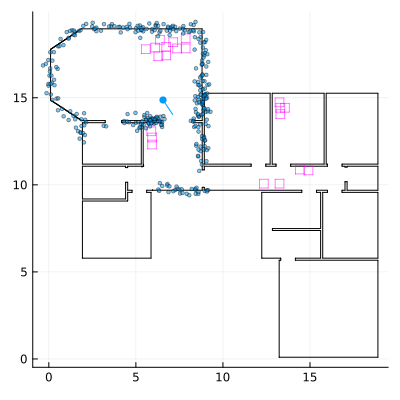

In [94]:
t = 7

p  = _ps[t]
m_ = _segs_

w            = 5
s_noise      = 0.2
outlier      = 0.1
outliver_vol = 100.0

args  = (p, m_, w, s_noise, outlier, outliver_vol)

tr = simulate(sensor_model_cu, args)
x = tr[]

ch = choicemap(:x => x)

@btime sensor_model_cu(args...) samples=3 evals=3;
@btime simulate(sensor_model_cu, args) samples=3 evals=3;
@btime generate(sensor_model_cu, args, ch) samples=5 evals=5;

# -------------------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
plot!(_boxes, c=:magenta, alpha=0.5)
scatter!(x.*_ps[t], c=col[1], alpha=0.5, markersize=2)
scatter!(_ps[t], c=col[1])